# Efecto Competencia

Se tratará de comprobar estadísticamente si hay relevancia estadística en el promedio de empeños mensuales en tiendas que tienen mayor número de tiendas de la comeptencia a 100 metros a la redonda que el promedio.

# Librerías

In [1]:
library(readr)
library(dplyr)
library(ggplot2)
library(forcats)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Leer datos

## KPIs tiendas

In [2]:
data <- read_csv('/Users/darias/Desktop/Efecto_competencia/Data/store_kpis_historical.csv')
data$store <- as.character(data$store)

Parsed with column specification:
cols(
  store = col_double(),
  Origin_Year = col_double(),
  Origin_Month = col_double(),
  Origin_Day = col_double(),
  newLoans_made = col_double(),
  num_drops = col_double(),
  num_redeems = col_double(),
  num_active = col_double(),
  total_loanAmt = col_double(),
  avg_loanAmt = col_double()
)



## Competencia

In [3]:
com <- read_delim('/Users/darias/Desktop/Tiendas_empeño_mexico/distancias_ezpawn_denue.csv',delim = '|')

Parsed with column specification:
cols(
  num_tienda = col_double(),
  tienda_ezpawn = col_character(),
  tienda_denue = col_character(),
  direccion_denue = col_character(),
  latitud_ezpawn = col_double(),
  longitud_ezpawn = col_double(),
  latitud_denue = col_double(),
  longitud_denue = col_double(),
  dist = col_double(),
  cercania = col_double()
)



In [4]:
com$num_tienda <- as.character(com$num_tienda)

# Data Engineering

## Competencia cercana

Número de tiendas de la competencia en un radio <= 100 m a cada tienda de EF

In [5]:
# Tiendas de la competencia <= 0.1 km y quitar las mismas tiendas de la empresa
com %>%
 filter(dist <= 0.1,
        tienda_denue != 'empeño facil',
        tienda_denue != 'empeño_facil',
        tienda_denue != 'empeno facil',
        tienda_denue != 'empeño fácil',
        tienda_denue != 'empeno fácil',
        tienda_denue != 'empeño facil',
        tienda_denue != 'prestadinero',
        tienda_denue != 'presta dinero',
        tienda_denue != 'bazareño',
        tienda_denue != 'bazareno',
        tienda_denue != 'basareno',
        tienda_denue != 'bazarenio',
        tienda_denue != 'ezpawn') %>%
 group_by(num_tienda) %>%
 summarise(tiendas_competencia = n()) %>%
 rename('store' = 'num_tienda') -> com_cercana

Obtener promedio de número de tiendas de la competencia cercanas

In [6]:
avg_com <- com_cercana$tiendas_competencia %>% mean

In [7]:
avg_com

[1] 2.168539

Dejar tiendas que estén en tabla de competencia

In [8]:
data %>%
 filter(store %in% com_cercana$store) -> data

Agregar número de tiendas de la competencia

In [9]:
data %>%
 left_join(com_cercana, by = 'store') -> data

Agregar indicador de tiendas de la competencia cercanas arriba del promedio

In [10]:
data %>%
 mutate(ind_avg_competencia = ifelse(tiendas_competencia >= avg_com, 'Mucha competencia', 'Poca competencia')) -> data

Obtener KPIs mensuales

In [11]:
data %>%
 group_by(store,Origin_Year,Origin_Month,tiendas_competencia,ind_avg_competencia) %>%
 summarise(newLoans_made = sum(newLoans_made),
           num_drops     = sum(num_drops),
           num_redeems   = sum(num_redeems),
           num_active    = sum(num_active),
           total_loanAmt = sum(total_loanAmt),
           avg_loanAmt   = mean(avg_loanAmt)) -> data_mensual

Promedios de KPIs históricos por tienda

In [12]:
data_mensual %>%
 group_by(ind_avg_competencia) %>%
 summarise(avg_newLoans_made = mean(newLoans_made),
           avg_num_drops     = mean(num_drops),
           avg_num_redeems   = mean(num_redeems),
           avg_num_active    = mean(num_active),
           avg_total_loanAmt = mean(total_loanAmt),
           avg_avg_loanAmt   = mean(avg_loanAmt)) -> avg_historicos

# Descriptivos

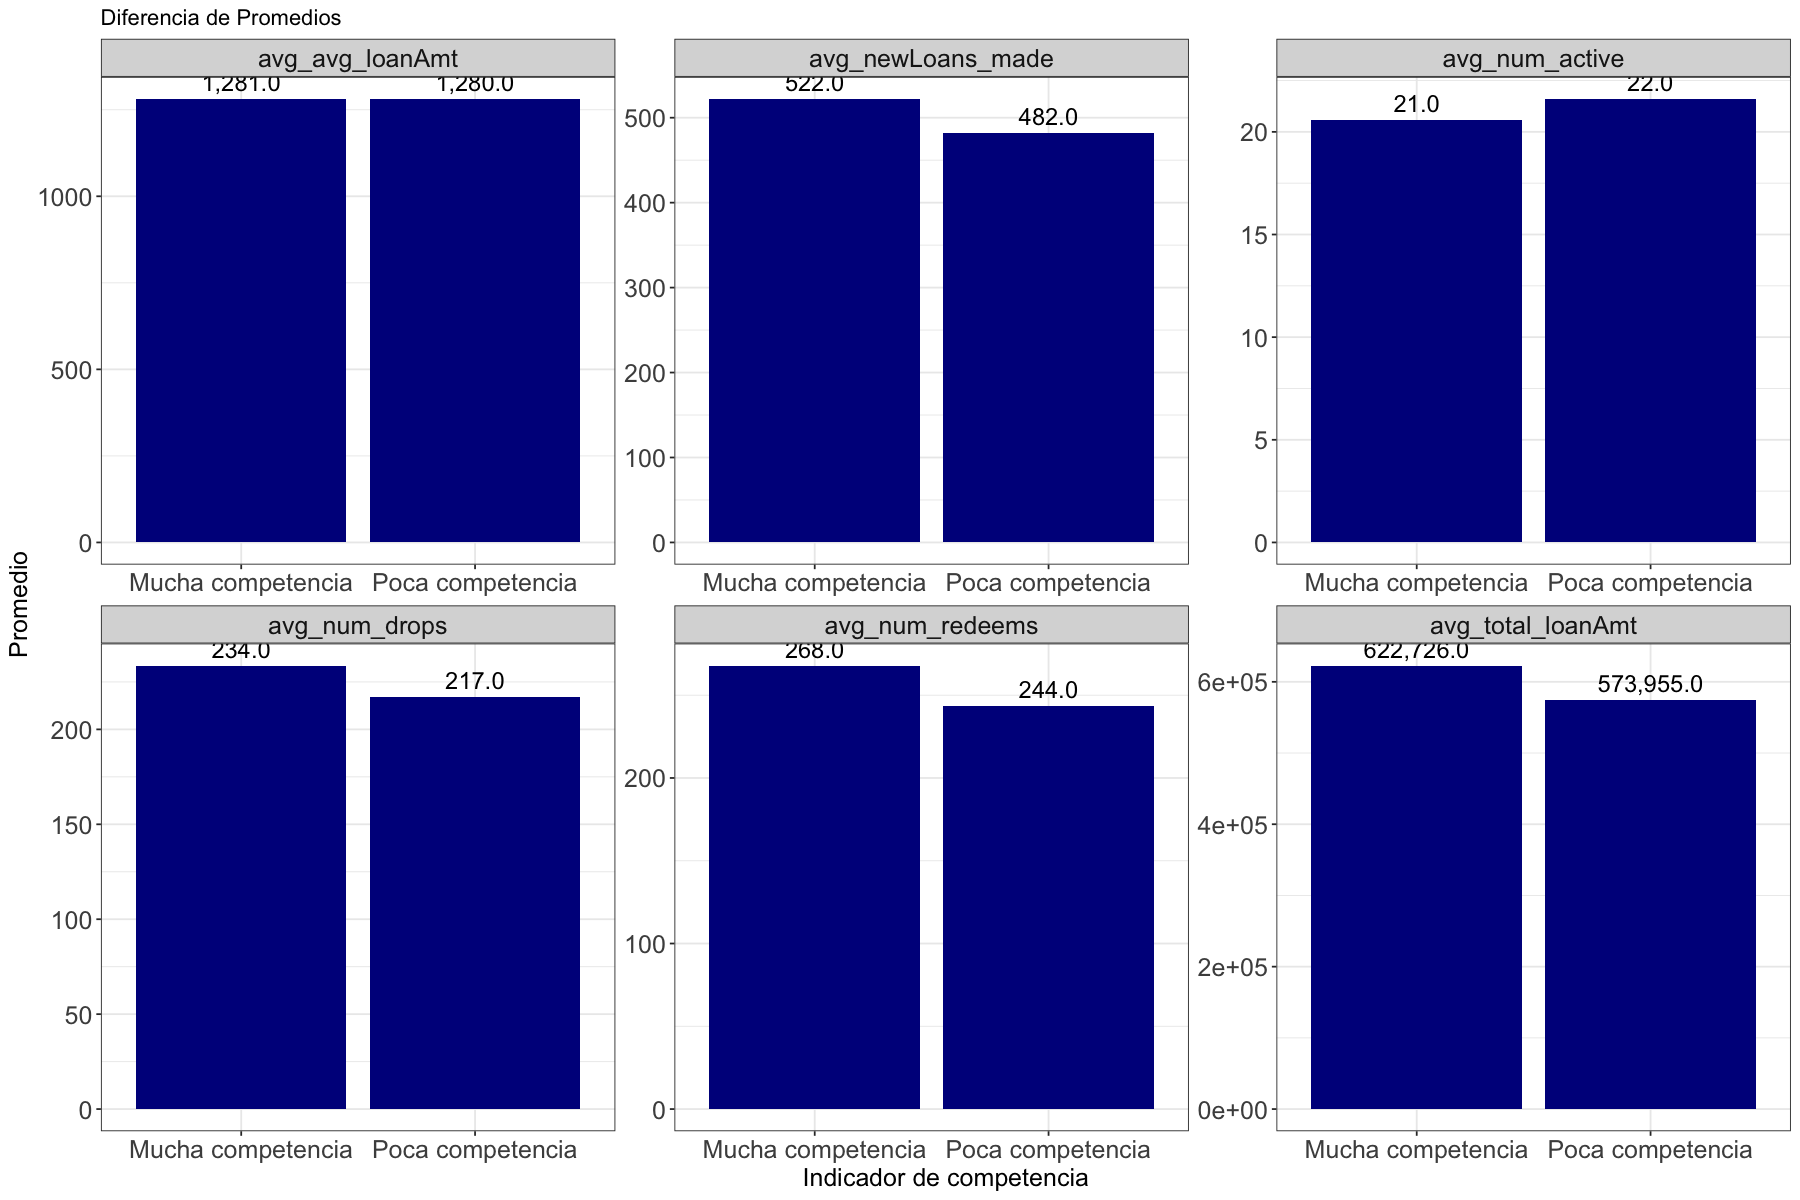

In [13]:
options(repr.plot.width=15, repr.plot.height=10)

avg_historicos %>%
 tidyr::gather(key,value,2:ncol(.)) %>%
 ggplot() +
 geom_col(aes(x = ind_avg_competencia, y = value), fill = 'darkblue')  +
 ggtitle('Diferencia de Promedios') +
 theme_bw() +
 xlab('Indicador de competencia') +
 ylab('Promedio') +
 facet_wrap(~key, scales = 'free') +
 theme(axis.title.x = element_text(size = 15),
       axis.title.y = element_text(size = 15),
       axis.text.x  = element_text(size = 15),
       axis.text.y  = element_text(size = 15),
       strip.text.x = element_text(size = 15)) +
 geom_text(aes(x = ind_avg_competencia, y = value, label = scales::comma(round(value))),
           size = 5, vjust = -0.5)


In [14]:
avg_historicos

ind_avg_competencia avg_newLoans_made avg_num_drops avg_num_redeems
1 Mucha competencia   522.0056          233.5748      267.8595       
2 Poca competencia    482.2974          217.1481      243.5491       
  avg_num_active avg_total_loanAmt avg_avg_loanAmt
1 20.57128       622726.4          1280.992       
2 21.60024       573955.3          1280.109

# Prueba de hipótesis

Ver si la diferencia de medias es estadísticamente significativa, tomando como hipótesis nula que la media de nuevos préstamos con muchas tiendas de la competencia cercanas es mayor que en aquellas tiendas con pocas tiendas de la competencia cercanas.

Esto con una significancia de $\alpha = 0.01 = \text{1%}$

$$\mu_1 = \text{Media de préstamos nuevos, tiendas con poca competencia}$$

$$\mu_2 = \text{Media de préstamos nuevos, tiendas con mucha competencia}$$

$$\mu_2 > \mu_1 \Leftrightarrow \mu_2 - \mu_1 > 0$$

$$H_0 = \mu_2 - \mu_1 = 0$$
$$H_1 = \mu_2 - \mu_1 > 0$$

In [15]:
data_mensual %>%
 group_by(ind_avg_competencia) %>%
 summarise(avg_newLoans_made = mean(newLoans_made),
           sd_newLoans_made  = mean(newLoans_made),
           cases             = n()) -> tabla_test

In [16]:
tabla_test

ind_avg_competencia avg_newLoans_made sd_newLoans_made cases
1 Mucha competencia   522.0056          522.0056         1964 
2 Poca competencia    482.2974          482.2974         5023

Guardar datos en objetos diferentes

In [17]:
n2 <- tabla_test %>% filter(ind_avg_competencia == 'Mucha competencia') %>% select(cases) %>% pull
n1 <- tabla_test %>% filter(ind_avg_competencia != 'Mucha competencia') %>% select(cases) %>% pull

x2 <- tabla_test %>% filter(ind_avg_competencia == 'Mucha competencia') %>% select(avg_newLoans_made) %>% pull
x1 <- tabla_test %>% filter(ind_avg_competencia != 'Mucha competencia') %>% select(avg_newLoans_made) %>% pull

sd2 <- tabla_test %>% filter(ind_avg_competencia == 'Mucha competencia') %>% select(sd_newLoans_made) %>% pull
sd1 <- tabla_test %>% filter(ind_avg_competencia != 'Mucha competencia') %>% select(sd_newLoans_made) %>% pull

grados_libertad <- n1+n2-2
t_value <- round(qt(p = 0.01, 27, lower.tail = FALSE),3)


Cálculo de $\delta_p$

$$\delta_p = \sqrt{\frac{(n_1 - 1)\delta_1^2 + (n_2 - 1)\delta_2^2}{n_1 + n_2 - 2}}$$

In [18]:
delta_p <- sqrt(( ((n1-1)*sd1^2) + ((n2-1)*sd2^2) ) / (n1 + n2 - 2))


In [19]:
delta_p


[1] 493.7794

Obtener el estadístico _t_

$$t = \frac{(\overline x_2 - \overline x_1) - d_0}{\delta_p \sqrt{\frac{1}{n_2} + \frac{1}{n_1}}}$$

In [20]:
t_stat <- (x2-x1-0)/(sqrt((1/n2) + (1/n1))*delta_p)


In [21]:
t_stat <- round(t_stat,4)

## Conclusión

In [22]:
t_stat

[1] 3.0217

In [23]:
t_value

[1] 2.473

In [24]:
print(paste0("Cómo el estadístico t calculado es ", ifelse(t_stat > t_value, 'MAYOR', 'MENOR'), ' que la distribución t al 5%, entonces la hipótesis nula se ', ifelse(t_stat > t_value, 'RECHAZA', 'ACEPTA')))
print(paste0("Por lo que la diferencia entre medias de nuevos préstamos entre tiendas con mucha y poca competencia cercana ",ifelse(t_stat > t_value, 'SI', 'NO'), ' es significativa'))

[1] "Cómo el estadístico t calculado es MAYOR que la distribución t al 5%, entonces la hipótesis nula se RECHAZA"
[1] "Por lo que la diferencia entre medias de nuevos préstamos entre tiendas con mucha y poca competencia cercana SI es significativa"
